# Répartition, table de hashage

Il est facile de répartir des élèves en quatre groupe après les avoir triés par ordre croissant, les élèves dont les noms de famille commencent par *A* dans le premier groupe et ainsi de suite... Cette répartition peut poser un problème éthique parfois. 
On souhaite écrire une fonction de répartition qui affecte les étudiants dans un groupe parmi quatre :

* Cette fonction prend comme entrée le nom et le prénom.
* Le résultat ne dépend pas des autres noms présents dans la classe.
* Les groupes sont à peu près de taille identique.

In [1]:
%matplotlib inline

## Q1 - première lettre

Ecrire une fonction qui retourne la distribution la première lettre de chaque personnage. Est-ce une distribution uniforme ?

In [2]:
personnages = """
Jean Valjean
Cosette
Fantine
Marius Pontmercy
Gavroche Thénardier
Antagonistes
Javert
Monsieur Thénardier
Madame Thénardier
Babet
Claquesous
Montparnasse
Gueulemer
Brujon
Bamatabois
Madame Victurnien
Les Amis de l'ABC
Enjolras
Combeferre
Courfeyrac
Jean Prouvaire
Feuilly
Bahorel
Lesgle
Joly
Grantaire
Marius Pontmercy
Personnages secondaires
Amies de Fantine
Favourite
Dahlia
Zéphine
Amis de Félix Tholomyès
Listolier
Fameuil
Blachevelle
Autres
Fauchelevent
Mr Mabeuf
Azelma Thénardier
Toussaint
Luc-Esprit Gillenormand
Georges Pontmercy
Évêque Myriel
Baptistine Myriel
Mme Magloire
Petit-Gervais
"""

## Q2 - somme

On écrit une fonction qui fait la somme des lettres (avec la fonction [ord](https://docs.python.org/3/library/functions.html?highlight=ord#ord) par exemple). On calcule ensuite la distribution du résultat modulo 26. Est-ce uniforme ?

## Q3 - pseudo générateur

On s'inspire d'un [générateur congruentiel linéaire](https://fr.wikipedia.org/wiki/G%C3%A9n%C3%A9rateur_congruentiel_lin%C3%A9aire).

$X_{n+1} = (22695477 X_n + 1) \mod 2^{32}$ qu'on transforme en $X_{n+1} = (22695477 (X_n + c_n) + 1) \mod 2^{32}$ où $c_n$ est la n-énième lettre du nom du personnage.

On prendra comme résultat le dernier nombre de la série $X_n >> 16$, le tout module 26. On calcule de nouveau la distribution.

## Q4 - hash

On utilise un algorithme hashage implémenté par la librairie [hashlib](https://docs.python.org/3/library/hashlib.html). On transforme chaque nom des personnages et on calcule la distribution de la première lettre du *hash* obtenu.

## Q5 - light hash

On s'inspire de la page [Hash Functions](http://www.cse.yorku.ca/~oz/hash.html).

```c
    unsigned long
    hash(unsigned char *str)
    {
        unsigned long hash = 5381;
        int c;

        while (c = *str++)
            hash = ((hash << 5) + hash) + c; /* hash * 33 + c */

        return hash;
    }
```

De nouveau calculer la distribution du hash obtenu.

## Q6 - répartition

Imagine une façon de répartir des élèves en 4 groupes.

## Q7 - dictionnaire

Les dictionnaires en python s'appuient sur une table de hashage et non sur un arbre de recherche dichotomique (voir aussi son code : [taille de hash](https://github.com/python/cpython/blob/main/Objects/dictobject.c#L38)). Quelle expérience pourrait-on mener pour s'assurer ? Le module [timeit](https://docs.python.org/3/library/timeit.html) pourrait vous mettre sur la voie.

## Quelques éléments de réponses

### Première lettre

In [3]:
d = {}
for m in personnages.split("\n"):
    if len(m) == 0:
        continue
    if m[0] in d:
        d[m[0]] += 1
    else:
        d[m[0]] = 1
d

{'J': 4,
 'C': 4,
 'F': 5,
 'M': 8,
 'G': 4,
 'A': 5,
 'B': 6,
 'L': 4,
 'E': 1,
 'P': 2,
 'D': 1,
 'Z': 1,
 'T': 1,
 'É': 1}

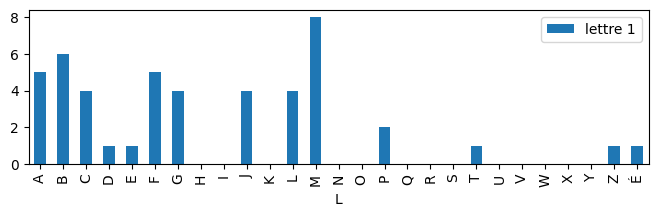

In [4]:
import matplotlib.pyplot as plt
import pandas


def draw(*ds_legends):
    fig, ax = plt.subplots(len(ds_legends) // 2, 1, figsize=(8, len(ds_legends)))
    i = 0
    while i < len(ds_legends):
        d = ds_legends[i].copy()
        for a in "abcdefghijklmnopqrstuvwxyz".upper():
            if a not in d:
                d[a] = 0
        legend = ds_legends[i + 1]
        df = (
            pandas.DataFrame(d.items(), columns=["L", legend])
            .sort_values("L")
            .set_index("L")
        )
        df.plot.bar(ax=ax[i // 2] if len(ds_legends) > 2 else ax)
        i += 2
    return ax


draw(d, "lettre 1");

### Somme

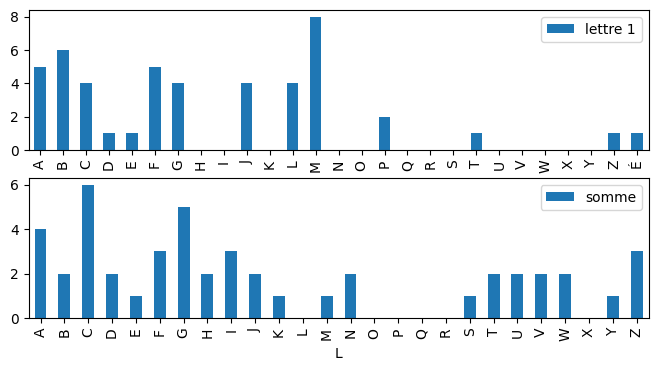

In [5]:
def somme(mot):
    s = 0
    for c in mot.lower():
        s += ord(c) - ord("a")
    return chr(s % 26 + ord("A"))


def repartition(fct):
    d = {}
    for m in personnages.split("\n"):
        if len(m) == 0:
            continue
        key = fct(m)
        if key in d:
            d[key] += 1
        else:
            d[key] = 1
    return d


d2 = repartition(somme)
draw(d, "lettre 1", d2, "somme");

### Pseudo

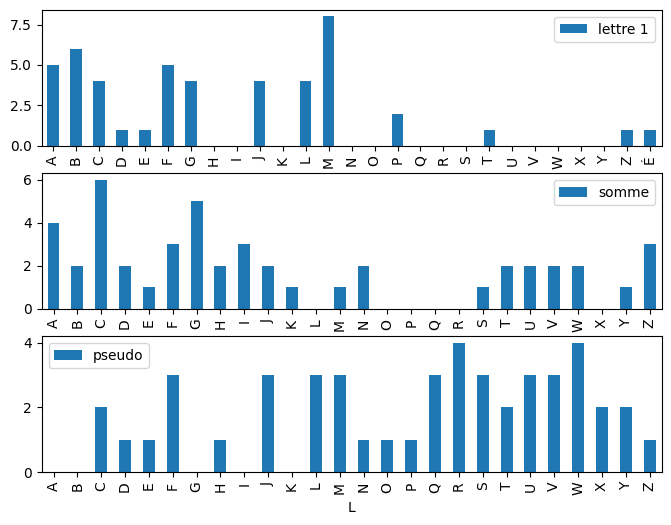

In [6]:
def pseudo(mot):
    s = 0
    for c in mot.lower():
        n = ord(c) - ord("a")
        s = (22695477 * (s + n) + 1) % 2**32
    return chr(s % 26 + ord("A"))


d3 = repartition(pseudo)
draw(d, "lettre 1", d2, "somme", d3, "pseudo");

### Hash

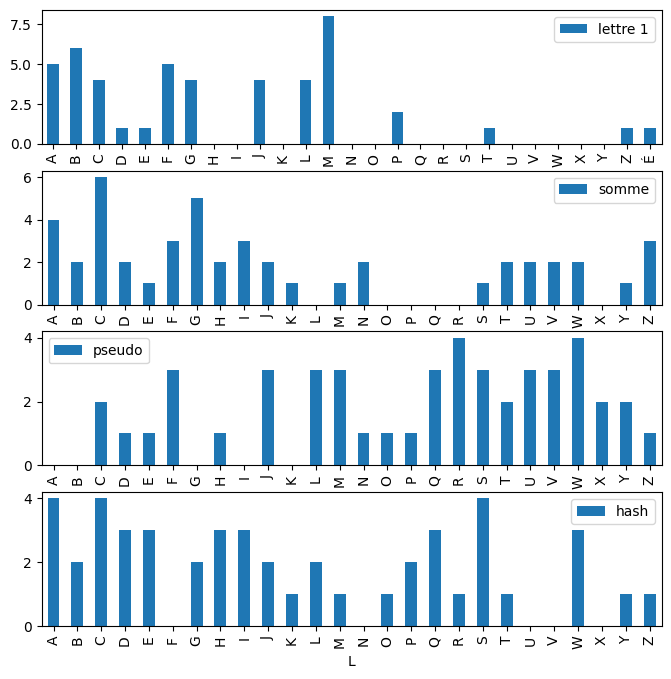

In [7]:
import hashlib


def hash(mot):
    m = hashlib.sha256()
    m.update(mot.encode("utf-8"))
    h = m.digest()
    s = h[0]
    return chr(s % 26 + ord("A"))


d4 = repartition(hash)
draw(d, "lettre 1", d2, "somme", d3, "pseudo", d4, "hash");

### Light hash

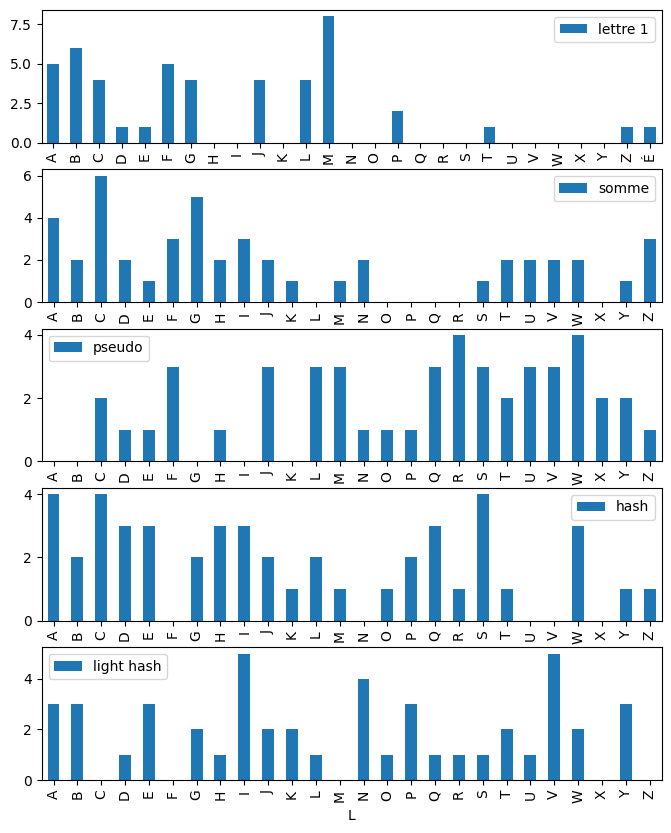

In [8]:
def light_hash(mot):
    mot = mot.encode("utf-8")
    x = 5381
    for c in mot:
        x = ((x << 5) + x) + c
    return chr(x % 26 + ord("A"))


d5 = repartition(light_hash)
draw(d, "lettre 1", d2, "somme", d3, "pseudo", d4, "hash", d5, "light hash");

### Q7

Il faut mesurer l'accès à des éléments d'un dictionnaire de différentes tailles.